In [1]:
import os
import random
import collections

import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
def background_noise(*size: int, cutoff: float = 1e-7) -> np.ndarray:
    """Generates random DE values under the null hypothesis.
    
    In the absence of any biological signal, p-values can be expected to be 
    uniformly distributed. Also, poitive and negative DE values are equally likely.
    
    Args:
        size: shape of the output tensor.
        cutoff: Significance threshold used to make sure we don't introduce huge outliers in the data.
            This cutoff does not have a real statistical meaning, and is only meant for numerical stability.
            P-values will be randomly and uniformly sampled from the ``[cutoff, 1]`` interval.
        device: Device where to do the computations (cpu or gpu).
    """
    sign = 2 * np.random.randint(0, 2, size) - 1
    return sign * np.log10(cutoff + np.random.rand(*size) * (1. - cutoff))

In [3]:
# Data location
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'

# Cell types for which all compounds are available in training set
TRAIN_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types for which some compounds are available in test set
TEST_CELL_TYPES = ['Myeloid cells', 'B cells']

# All cell types
CELL_TYPES = TRAIN_CELL_TYPES + TEST_CELL_TYPES

# Load DE data, as well as the cell type, compound and SMILES for each row
df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))
cell_types = df['cell_type']
sm_names = df['sm_name']
all_smiles = df['SMILES']

# Convert Pandas dataframe to NumPy array
for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

# Gene names, ordered by columns
gene_names = list(df.columns)
gene_name_dict = {gene_name: i for i, gene_name in enumerate(gene_names)}

# Unique compound names and cell types
unique_sm_names = list(set(sm_names))
unique_cell_types = list(set(cell_types))

# Dict to map compounds to their SMILES
sm_name_to_smiles = {sm_name: smiles for sm_name, smiles in zip(sm_names, all_smiles)}

# Make a dict version of the data matrix, to easily access the DE values
# given the cell type and compound
data_dict = {}
for p in range(len(sm_names)):
    if sm_names[p] not in data_dict:
        data_dict[sm_names[p]] = {}
    data_dict[sm_names[p]][cell_types[p]] = data[p, :]

# Identify compounds for which all cell types are available
train_sm_names = set()
for sm_name in data_dict.keys():
    if len(data_dict[sm_name]) == len(unique_cell_types):
        train_sm_names.add(sm_name)

# Count, for each (cell_type, compound) pair, how many cells were used to infer the DE values
df = pd.read_csv(os.path.join(DATA_FOLDER, 'adata_obs_meta.csv'), header='infer', delimiter=',')
cell_count_dict = collections.Counter(zip(df['cell_type'], df['sm_name']))
cell_counts = np.asarray([cell_count_dict[key] for key in zip(cell_types, sm_names)])

In [4]:
# Load ID mapping
id_map = {}
with open(os.path.join(DATA_FOLDER, 'id_map.csv'), 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        elements = line.rstrip().split(',')
        id_map[int(elements[0])] = elements[1:]

In [5]:
SEED = 0xCAFE

random.seed(SEED)
np.random.seed(SEED)

In [63]:
EXTRA_FOLDER = '/kaggle/input/op2-submissions'

# Jalil's local ensemble
df_jalil = pd.read_csv(os.path.join(EXTRA_FOLDER, 'jalil.csv'), index_col='id')

# Version 15 of https://www.kaggle.com/code/antoinepassemiers/op2-de-dl
df_dl40 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'dl40.csv'), index_col='id')
df_dl200 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-de-dl.csv'), index_col='id')

# df_dl_gene_cat = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-dl-with-gene-categories.csv'), index_col='id')

df_dl_bio_nets = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-dl-with-bio-nets.csv'), index_col='id')

#df_gnn = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-de-gnn.csv'), index_col='id')

# Version 7 of https://www.kaggle.com/antoinepassemiers/op2-rf
#df_rf = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-tree-ensembles.csv'), index_col='id')

df_gbm = pd.read_csv(os.path.join(EXTRA_FOLDER, 'gbm.csv'), index_col='id')

df_linear = pd.read_csv(os.path.join(EXTRA_FOLDER, 'linear.csv'), index_col='id')

# https://www.kaggle.com/code/jeanlucvanlite/only-lb-dont-select-as-final-submission-ensembling
df_public = pd.read_csv(os.path.join(EXTRA_FOLDER, 'best-public3.csv'), index_col='id')

# https://www.kaggle.com/code/olegpush/copy-of-pyboost-secret-grandmaster-s-to-f1b9ef/output?select=submission.csv
#df_public2 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-public-pyboost.csv'), index_col='id')

In [196]:
mu_prior = {}
sigma_prior = {}
for sm_name in tqdm.tqdm(unique_sm_names):
    for cell_type in unique_cell_types:
        weights = np.zeros(len(data))
        weights[sm_names == sm_name] = 1.0
        weights[cell_types == cell_type] = 0.1 # 0.001
        mu_prior[(sm_name, cell_type)] = np.average(data, axis=0, weights=weights)
        sigma_prior[(sm_name, cell_type)] = np.sqrt(np.average(np.square(data - mu_prior[(sm_name, cell_type)][np.newaxis, :]), weights=weights, axis=0))

100%|██████████| 146/146 [02:15<00:00,  1.08it/s]


In [177]:
# Load ID mapping
id_map = []
with open(os.path.join(DATA_FOLDER, 'id_map.csv'), 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        id_map.append(line.rstrip().split(',')[1:])
        assert len(id_map[-1]) == 2
Y_prior = []
std_prior = []
for sm_name, cell_type in id_map:
    Y_prior.append(mu_prior[(cell_type, sm_name)])
    std_prior.append(sigma_prior[(cell_type, sm_name)])
Y_prior = np.asarray(Y_prior)
std_prior = np.asarray(std_prior)

In [197]:
r2_jalil = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-jalil.npy'))
r2_gbm = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-gbm.npy'))
r2_linear = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-linear.npy'))
r2_dl40 = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl40.npy'))
r2_dl200 = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl200.npy'))
r2_dl_bio_nets = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl-bio-nets.npy'))
r2_all = np.asarray([
    # r2_jalil, r2_gbm, r2_dl40, r2_dl200, r2_dl_bio_nets
    r2_dl40, r2_dl200, r2_dl_bio_nets
])
# NAMES = ['Jalil', 'GBM', 'DL40', 'DL200', 'DL200-Bio-Nets', 'Prior']
NAMES = ['DL40', 'DL200', 'DL200-Bio-Nets', 'Prior']
# dfs = [df_jalil, df_gbm, df_dl40, df_dl200, df_dl_bio_nets]
dfs = [df_dl40, df_dl200, df_dl_bio_nets]
Y = np.asarray([df.to_numpy() for df in dfs])
Y = np.concatenate((Y, Y_prior[np.newaxis, :, :]), axis=0)
print(Y.shape)

ss_tot = np.var(data, axis=0, ddof=1)[np.newaxis, :]
ss_res_all = ss_tot * (1 - r2_all)
sigma = np.tile(np.sqrt(ss_res_all)[:, np.newaxis, :], (1, Y.shape[1], 1))
sigma = np.concatenate((sigma, std_prior[np.newaxis, :, :]), axis=0)
print(sigma.shape)

(4, 255, 18211)
(4, 255, 18211)


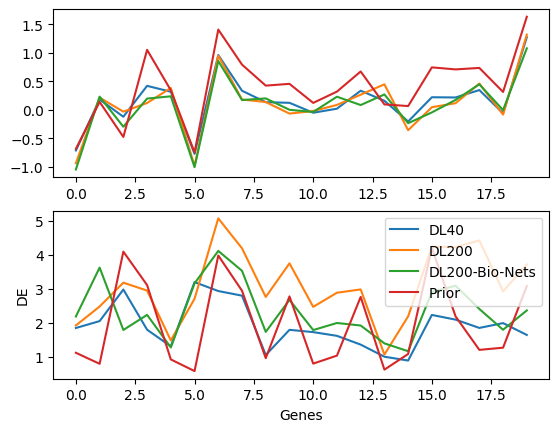

In [198]:
k = 14290
j = 121
plt.subplot(2, 1, 1)
for i in range(len(Y)):
    plt.plot(Y[i, j, k:k+20], label=NAMES[i])
plt.subplot(2, 1, 2)
for i in range(len(Y)):
    plt.plot(sigma[i, j, k:k+20], label=NAMES[i])
plt.xlabel('Genes')
plt.ylabel('DE')
plt.legend()
plt.show()

In [199]:
numerator = np.sum(Y / np.square(sigma), axis=0)
denominator = np.sum(1 / np.square(sigma), axis=0)
Y_ensemble = numerator / denominator

In [200]:
#mask = (np.max(r2_all, axis=0) < 0)
#Y_ensemble[:, mask] = np.median(data, axis=0)[mask]
#np.sum(mask)

In [201]:
df_ensemble = df_gbm.copy()
df_ensemble.loc[:, :] = Y_ensemble

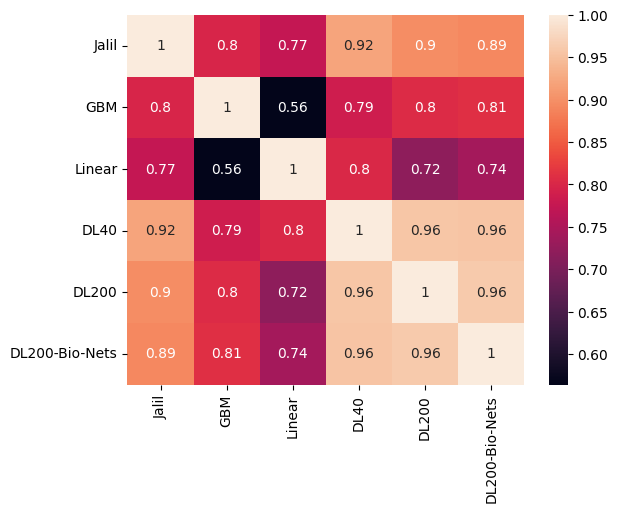

In [18]:
corr = np.corrcoef(Y.reshape(len(Y), -1))
seaborn.heatmap(corr, annot=True)
plt.xticks(0.5 + np.arange(len(dfs)), NAMES, rotation=90)
plt.yticks(0.5 + np.arange(len(dfs)), NAMES, rotation=0)
plt.show()

In [ ]:
signs = np.sign(Y)
np.mean(np.all(signs[0, np.newaxis, ...] == signs, axis=0))

In [ ]:
def compare_submissions(i, j):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 2, 1)
    xs = Y[i, :128].flatten()
    ys = Y[j, :128].flatten()
    #xs = Y[i, 147]
    #ys = Y[j, 147]
    plt.scatter(xs, ys, alpha=0.05)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.set_xlabel(NAMES[i])
    ax.set_ylabel(NAMES[j])
    ax.set_xlim([-40, 70])
    ax.set_ylim([-40, 50])
    ax.set_title('B cells')
    ax.plot([-40, 40], [-40, 40], linestyle='--', color='black')

    ax = plt.subplot(1, 2, 2)
    xs = Y[i, 128:].flatten()
    ys = Y[j, 128:].flatten()
    #xs = Y[i, 149]
    #ys = Y[j, 149]
    plt.scatter(xs, ys, alpha=0.05)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.set_xlabel(NAMES[i])
    ax.set_ylabel(NAMES[j])
    ax.set_xlim([-40, 70])
    ax.set_ylim([-40, 50])
    ax.set_title('Myeloid cells')
    ax.plot([-40, 40], [-40, 40], linestyle='--', color='black')
    plt.show()

In [ ]:
compare_submissions(2, 3)

In [ ]:
compare_submissions(1, 0)

In [ ]:
def compare_against_background(i):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 1, 1)
    ax.hist(background_noise(10000), bins=200, density=True, alpha=0.4, label='Background noise')
    ys = Y[i].flatten()
    ys = ys[np.abs(ys) < 5]
    ax.hist(ys, bins=200, density=True, alpha=0.4, label='Estimated DE')
    ax.set_xlabel(f'DE ({NAMES[i]})')
    ax.set_ylabel('Density')
    ax.set_xlim([-5, 5])
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.legend()
    plt.show()

In [ ]:
for i in range(len(NAMES)):
    compare_against_background(i)

In [ ]:
"""
class gaussian_gen(scipy.stats.rv_continuous):

    def _pdf(self, x):
        return 0.5 * (10 ** (-np.abs(x)))
    
print(scipy.stats.goodness_of_fit(gaussian_gen(), Y[-1, :, 0]))

plt.hist(np.mean(np.abs(Y[-1, :, :]), axis=0), bins=300)
plt.show()
"""

In [ ]:
plt.hist(np.mean(np.abs(data), axis=0), bins=300)
plt.show()

In [202]:
final_pred = df_ensemble.to_numpy()

In [203]:
# Remove left-over outliers in predictions
lb = np.min(data, axis=0)
ub = np.max(data, axis=0)
for i in range(len(final_pred)):
    mask = (final_pred[i, :] > ub)
    final_pred[i, mask] = ub[mask] + 0.0024 * (final_pred[i, mask] - ub[mask])
    mask = (final_pred[i, :] < lb)
    final_pred[i, mask] = lb[mask] - 0.0024 * np.abs(lb[mask] - final_pred[i, mask])

In [204]:
df_ensemble.loc[:, :] = final_pred
df_ensemble.to_csv('submission.csv')

- 0.554: Best ensemble we had so far. 0.5 * DL + 0.5 * Public.

- 0.570: Taking mean of lymphoid cells (from the training data) if variance of lymphoid cells is lower than the variance of predictors, and taking the weighted mean of predictors otherwise. Weights are 0.25, 0.25, 0.25 and 0.25. These operations are performed for each (cell type, compound) pair of the test set and for each gene. Clipping the predictions at the end (like here: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/457864).

- 0.567: Taking mean of lymphoid cells if variance of lymphoid cells is lower than the variance of predictors, and taking the weighted mean of predictors otherwise. Weights are 0.1 * DL + 0.4 * DL-Bio-Nets + 0.4 * Public + 0.1 * Jalil. Weighted mean of predictors is replaced by the prediction from the public blend when the latter is higher than other predictors (in absolute value). These operations are performed for each (cell type, compound) pair of the test set and for each gene. Clipping the predictions at the end.

- 0.581: Taking mean of lymphoid cells if variance of lymphoid cells is lower than the variance of predictors, and taking the median of predictors otherwise. Also taking mean of lymphoid cells if gene is a "DE gene". These operations are performed for each (cell type, compound) pair of the test set and for each gene. A gene is a "DE gene" if its mean absolute DE is > 0.75. Based on this definition, 53.6% of the genes are DE.

- 0.559: Taking the prediction from Public (most conservative submission) if gene is not a "DE gene", and take it from DL-Bio-Nets (less conservative submission) otherwise. These operations are performed for each (cell type, compound) pair of the test set and for each gene. A gene is a "DE gene" if its mean absolute DE is > 1.3. Based on this definition, 8.3% of the genes are DE.

- 0.560: Taking the prediction from Public if gene is not a "DE gene", and compute it as 0.5 * DL-Bio-Nets + 0.5 * DL otherwise. These operations are performed for each (cell type, compound) pair of the test set and for each gene. A gene is a "DE gene" if its mean absolute DE is > 1.1. Based on this definition, 18.1% of the genes are DE. Clipping the predictions at the end.

---

- 0.572: 0.7 * Ensemble + 0.15 * Public + 0.15 Public2. Ensemble combines our submissions in a per-gene fashion. For each gene, Ensemble uses the prediction from the submission with highest r2 validation score for that gene. Ensemble contained {GBM, Linear, DL40, DL200, DL-Bio-Nets}.

- 0.572: 0.7 * Ensemble + 0.15 * Public + 0.15 Public2. Ensemble combines our submissions in a per-gene fashion. For each gene, Ensemble uses the prediction from the submission with highest r2 validation score for that gene. Ensemble contained {GBM, DL40, DL200, DL-Bio-Nets}. Clipping the predictions at the end.

- 0.563: 0.7 * Ensemble + 0.15 * Public + 0.15 Public2. Ensemble combines our submissions in a per-gene fashion. For each gene, Ensemble is the average of {GBM, DL40, DL200, DL-Bio-Nets}. Clipping CORRECTLY the predictions at the end (just found an obvious bug ^^').

- 0.574: When the best r2 for a particular gene is <0, then predict all zeros. If best r2 is in [0, 0.3], then predict using Public. Otherwise, predict using the submission that produced that r2 score. Clipping correctly the predictions at the end.

- 0.565: 0.4 * Ensemble + 0.3 * Median + 0.3 * Public. Ensemble combines our submissions in a per-gene fashion. For each gene, Ensemble uses the prediction from the submission with highest r2 validation score for that gene. If all submissions have a negative r2, then predict the average DE for that gene based on the training set. Median is the median prediction across all submissions. Clipping correctly the predictions at the end.